In [7]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
# from models.deepmsn import DeepMSN

device = torch.device(f'cuda:2')
print(f"Using {device} device")

Using cuda:2 device


In [9]:
with open('configs/config_dm-ctdnsmpl_top2k.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dm_ctdnsmpl_2k_2025-05-29_05-24-01'

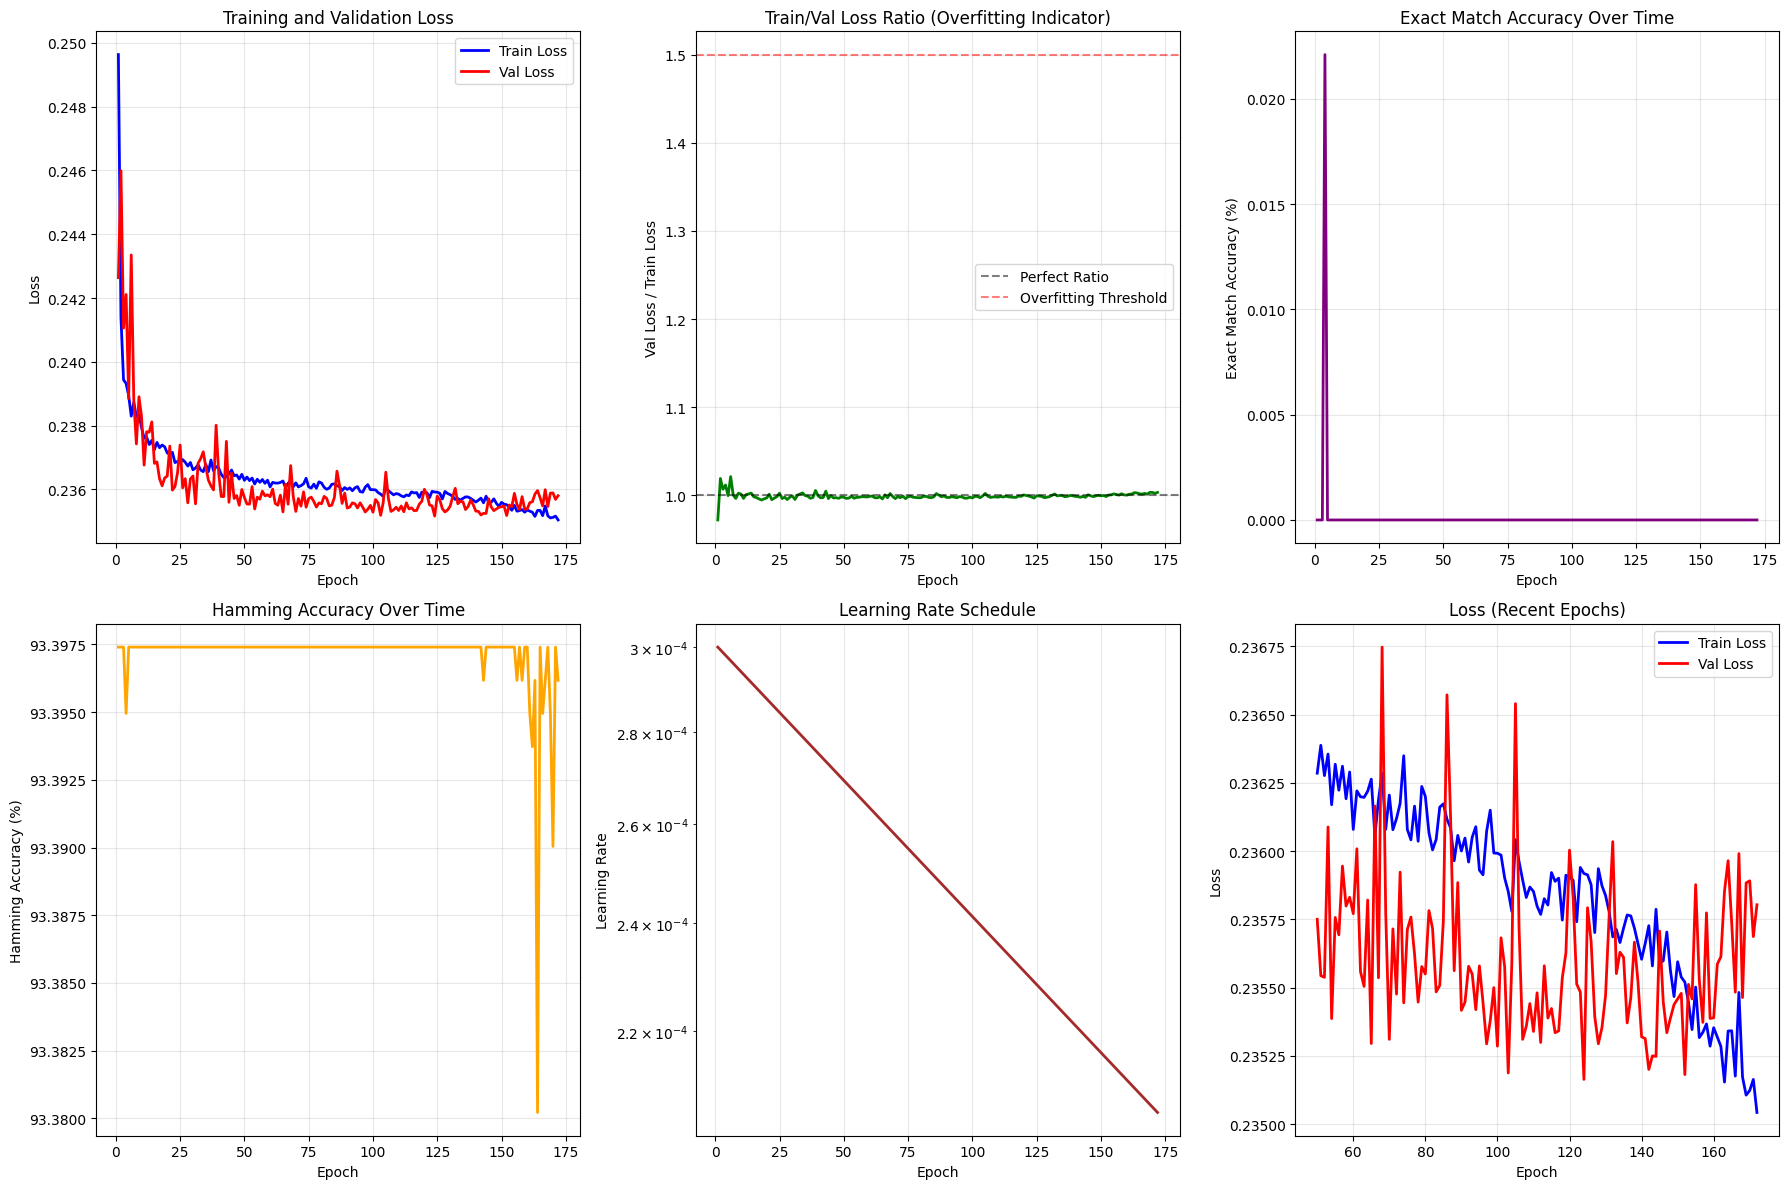

Training Summary:
Initial Train Loss: 0.249630
Final Train Loss: 0.235043
Initial Val Loss: 0.242640
Final Val Loss: 0.235803
Best Val Loss: 0.235164 (Epoch 124)
Best Exact Match Acc: 0.0002 (Epoch 4)
Best Hamming Acc: 0.9340 (Epoch 1)
Final Train/Val Ratio: 1.003


In [10]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

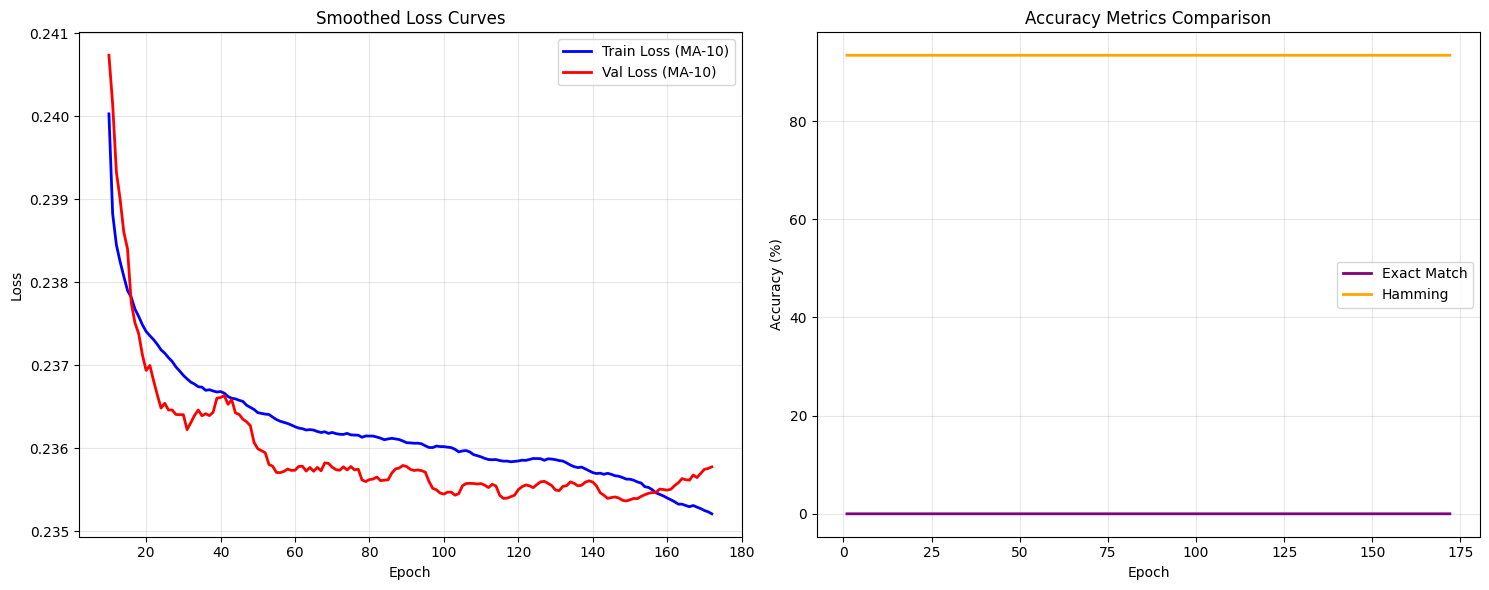

In [11]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

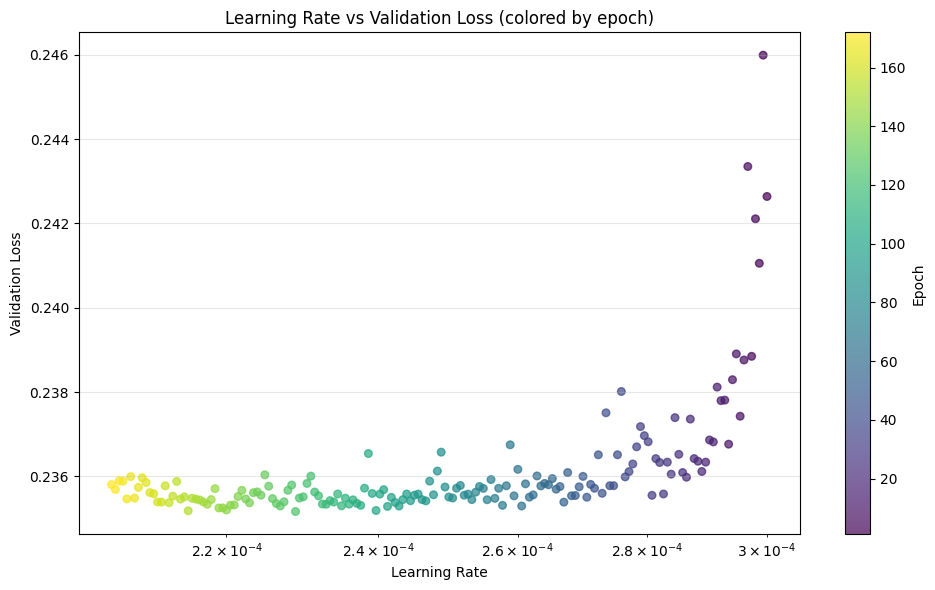

In [12]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [13]:
# Training phases analysis
print("Training Phases Analysis:")
print("=" * 50)

# Phase 1: Initial training (epochs 1-50)
phase1 = training_df[training_df['epoch'] <= 50]
print(f"Phase 1 (Epochs 1-50):")
print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# Phase 2: Middle training (epochs 51-200)
phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
print(f"\nPhase 2 (Epochs 51-200):")
print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# Phase 3: Fine-tuning (epochs 201-300)
phase3 = training_df[training_df['epoch'] > 200]
print(f"\nPhase 3 (Epochs 201-300):")
print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# Identify potential overfitting
overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
if len(overfitting_epochs) > 0:
    print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
    print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
    print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
else:
    print(f"\nNo significant overfitting detected (all ratios < 1.5)")

Training Phases Analysis:
Phase 1 (Epochs 1-50):
  Loss reduction: 0.2496 → 0.2363
  Val loss reduction: 0.2426 → 0.2358
  Accuracy improvement: 0.0000 → 0.0000

Phase 2 (Epochs 51-200):
  Loss reduction: 0.2364 → 0.2350
  Val loss reduction: 0.2355 → 0.2358
  Best accuracy: 0.0000

Phase 3 (Epochs 201-300):


IndexError: single positional indexer is out-of-bounds

In [14]:
model_arch = config.get('train').get('model')

if model_arch == 'DeepMSN':
    from models.deepmsn import DeepMSN
    ModelClass = DeepMSN
elif model_arch == 'DeepFlyBrain':
    from models.deepflybrain import DeepFlyBrain
    ModelClass = DeepFlyBrain

In [19]:
# Resume model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/model_epoch_100.pth')

model = ModelClass(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [21]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [22]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [24]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 9.364029e-05 0.1940948
Prediction shape: (16087, 18)
Target shape: (16087, 18)


In [25]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0622
Topic 1: 0.0622
Topic 2: 0.0622
Topic 3: 0.0622
Topic 4: 0.0622
Topic 5: 0.0622
Topic 6: 0.0622
Topic 7: 0.0622
Topic 8: 0.0622
Topic 9: 0.0622
Topic 10: 0.0622
Topic 11: 0.0622
Topic 12: 0.0622
Topic 13: 0.0622
Topic 14: 0.0622
Topic 15: 0.0622
Topic 16: 0.0622
Topic 17: 0.0622


In [26]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[15087     0]
 [ 1000     0]]

Topic 1:
[[15087     0]
 [ 1000     0]]

Topic 2:
[[15087     0]
 [ 1000     0]]

Topic 3:
[[15087     0]
 [ 1000     0]]

Topic 4:
[[15087     0]
 [ 1000     0]]

Topic 5:
[[15087     0]
 [ 1000     0]]

Topic 6:
[[15087     0]
 [ 1000     0]]

Topic 7:
[[15087     0]
 [ 1000     0]]

Topic 8:
[[15087     0]
 [ 1000     0]]

Topic 9:
[[15087     0]
 [ 1000     0]]

Topic 10:
[[15087     0]
 [ 1000     0]]

Topic 11:
[[15087     0]
 [ 1000     0]]

Topic 12:
[[15087     0]
 [ 1000     0]]

Topic 13:
[[15087     0]
 [ 1000     0]]

Topic 14:
[[15087     0]
 [ 1000     0]]

Topic 15:
[[15087     0]
 [ 1000     0]]

Topic 16:
[[15087     0]
 [ 1000     0]]

Topic 17:
[[15087     0]
 [ 1000     0]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.6330, auPR: 0.0882, F1: 0.0000


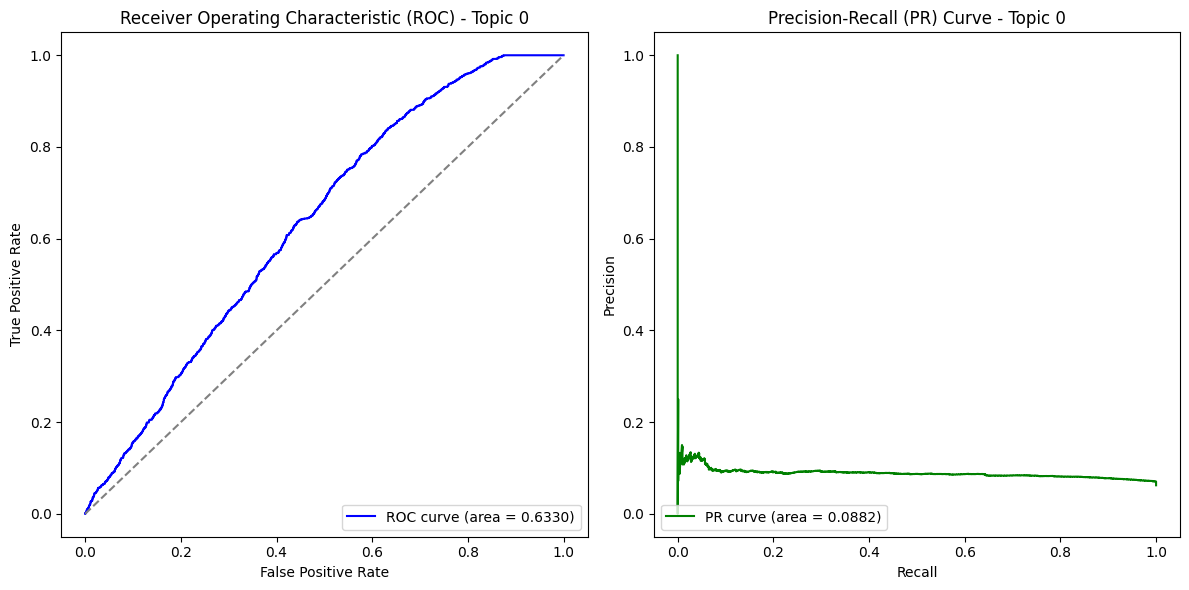

Evaluating topic 1
Topic 1 - auROC: 0.6704, auPR: 0.1221, F1: 0.0000


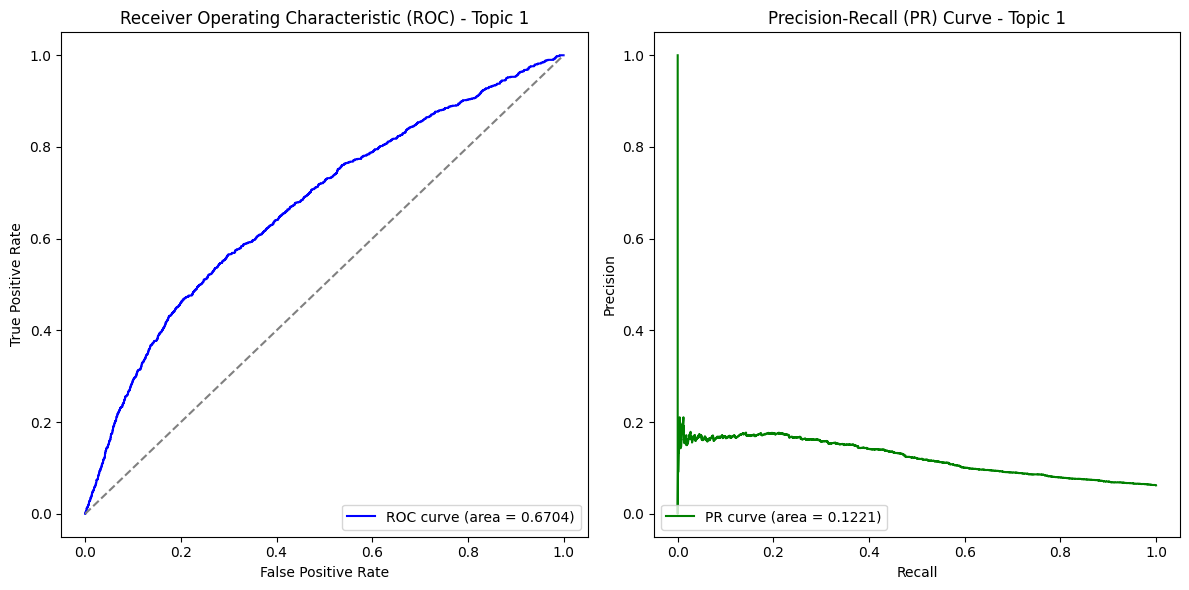

Evaluating topic 2
Topic 2 - auROC: 0.6045, auPR: 0.0826, F1: 0.0000


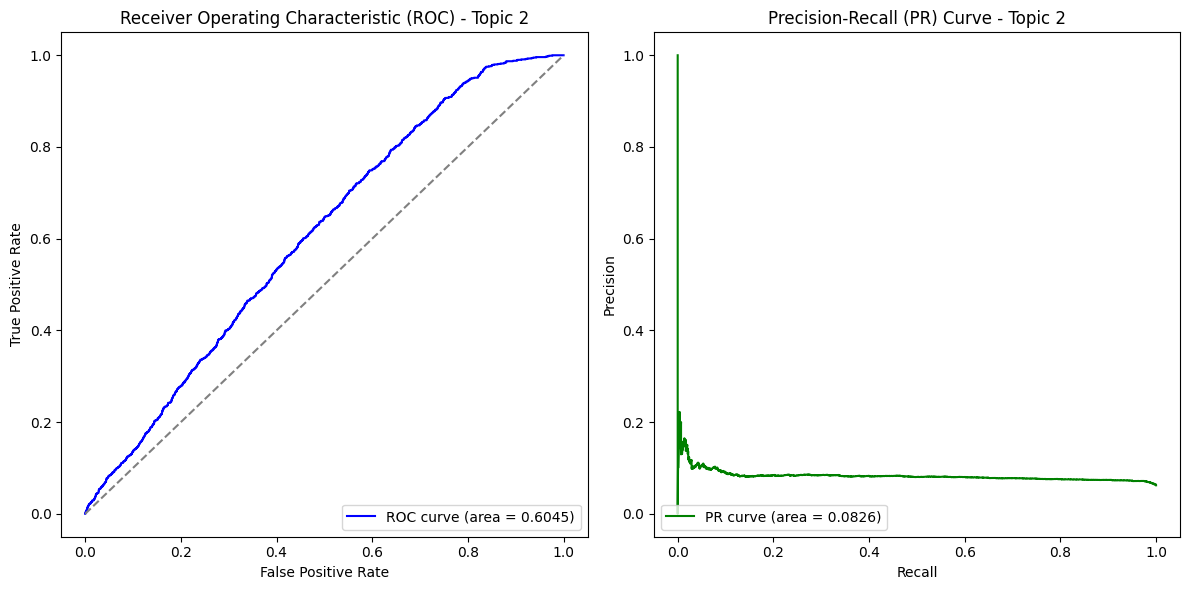

Evaluating topic 3
Topic 3 - auROC: 0.5315, auPR: 0.0707, F1: 0.0000


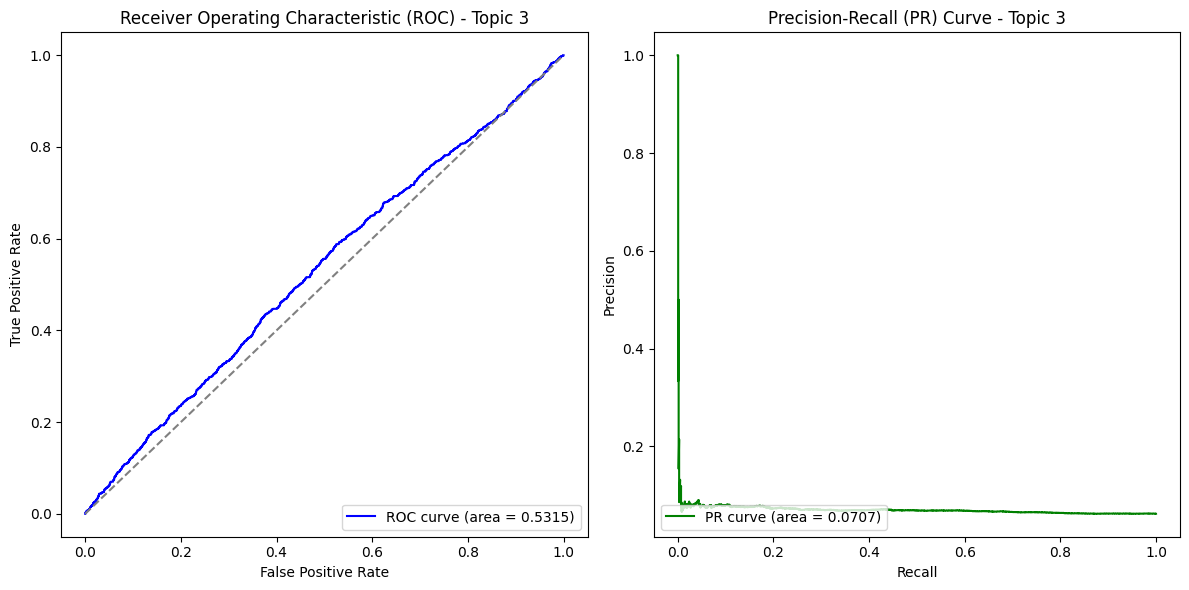

Evaluating topic 4
Topic 4 - auROC: 0.7228, auPR: 0.1363, F1: 0.0000


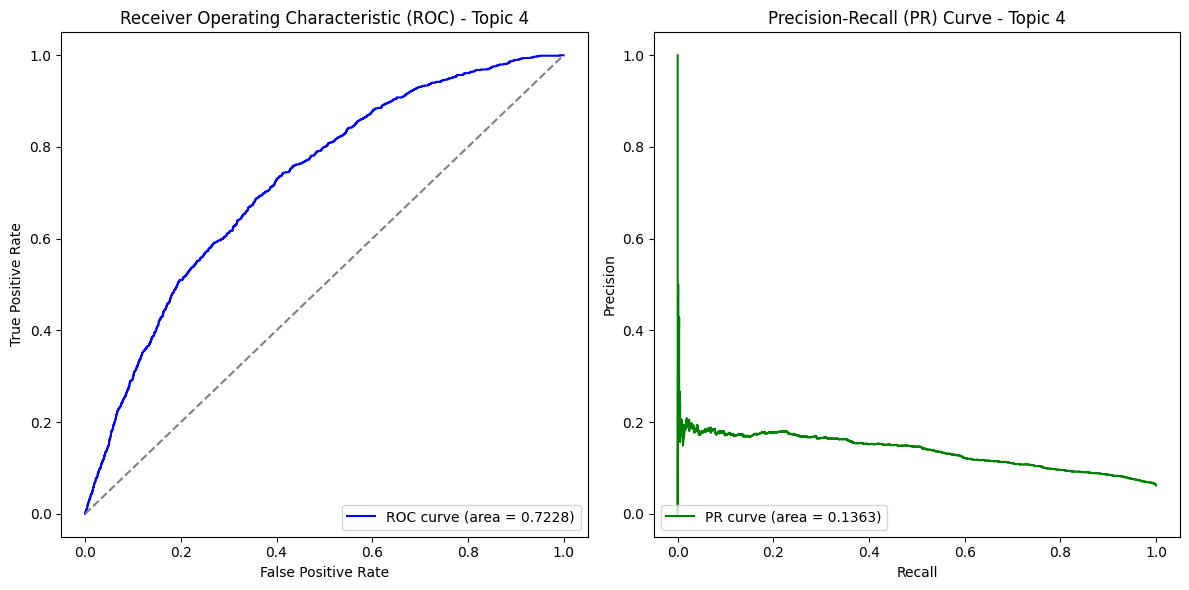

Evaluating topic 5
Topic 5 - auROC: 0.5802, auPR: 0.0776, F1: 0.0000


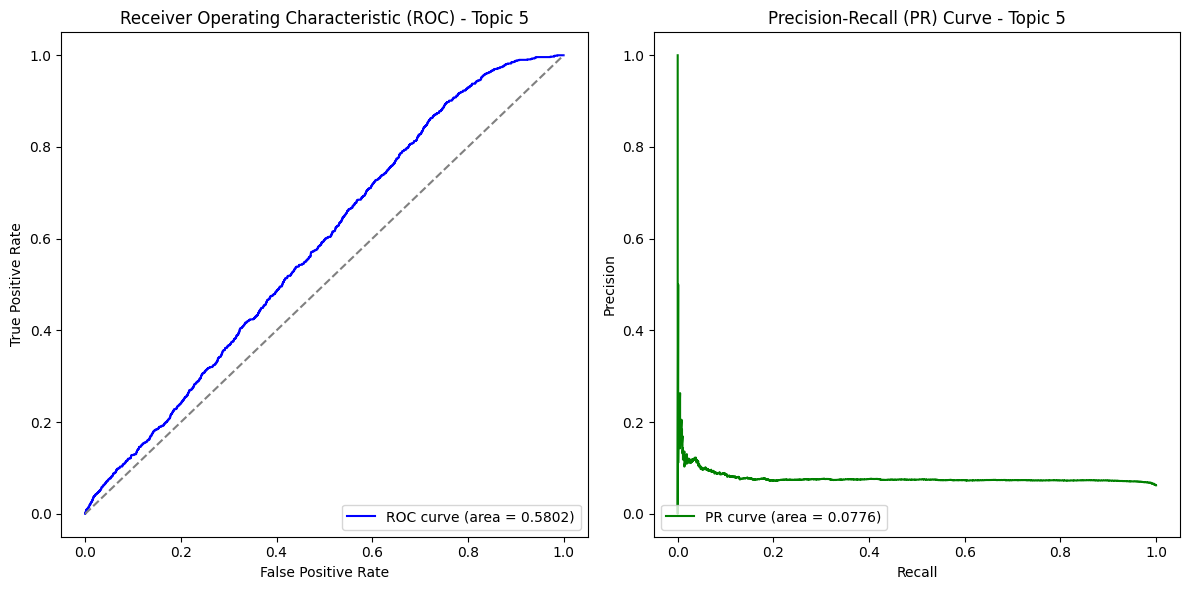

Evaluating topic 6
Topic 6 - auROC: 0.6319, auPR: 0.0881, F1: 0.0000


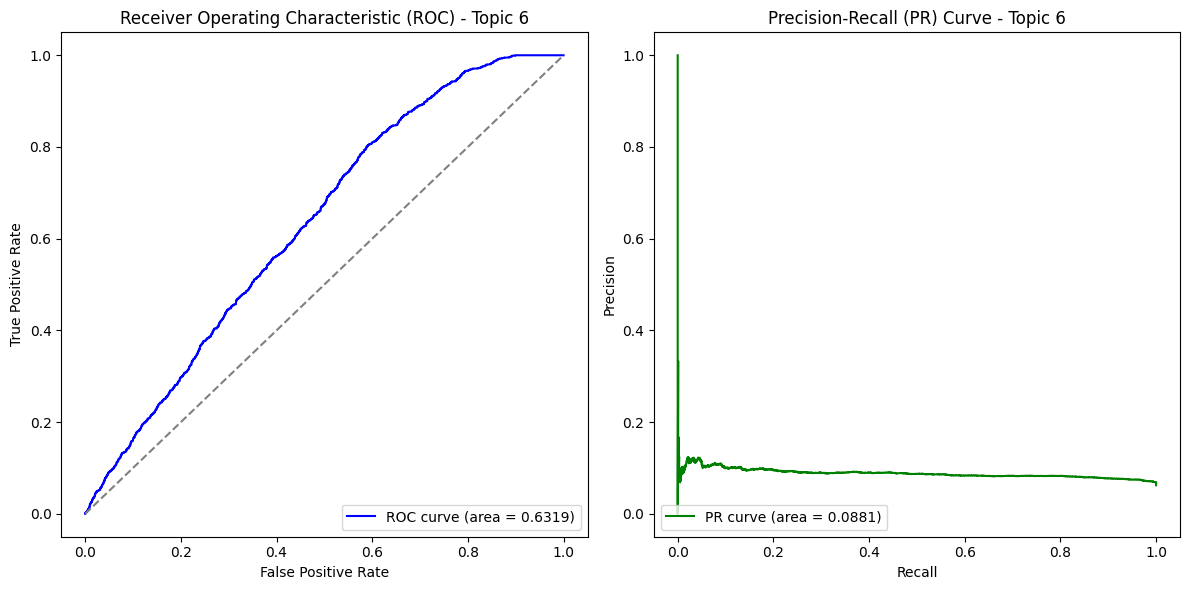

Evaluating topic 7
Topic 7 - auROC: 0.6014, auPR: 0.0788, F1: 0.0000


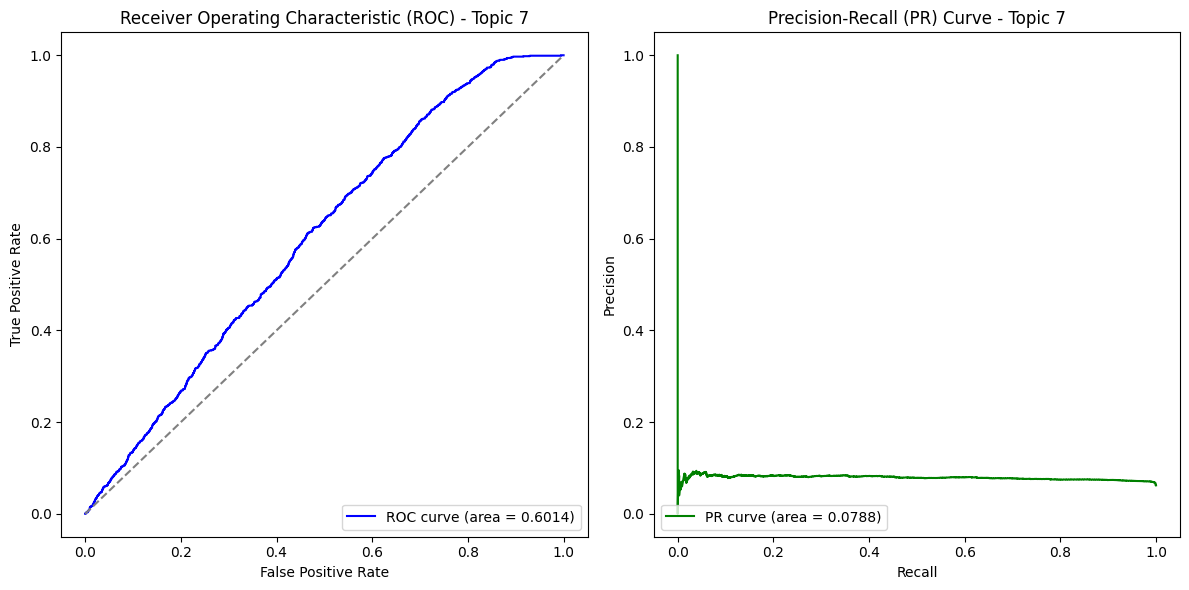

Evaluating topic 8
Topic 8 - auROC: 0.6390, auPR: 0.1085, F1: 0.0000


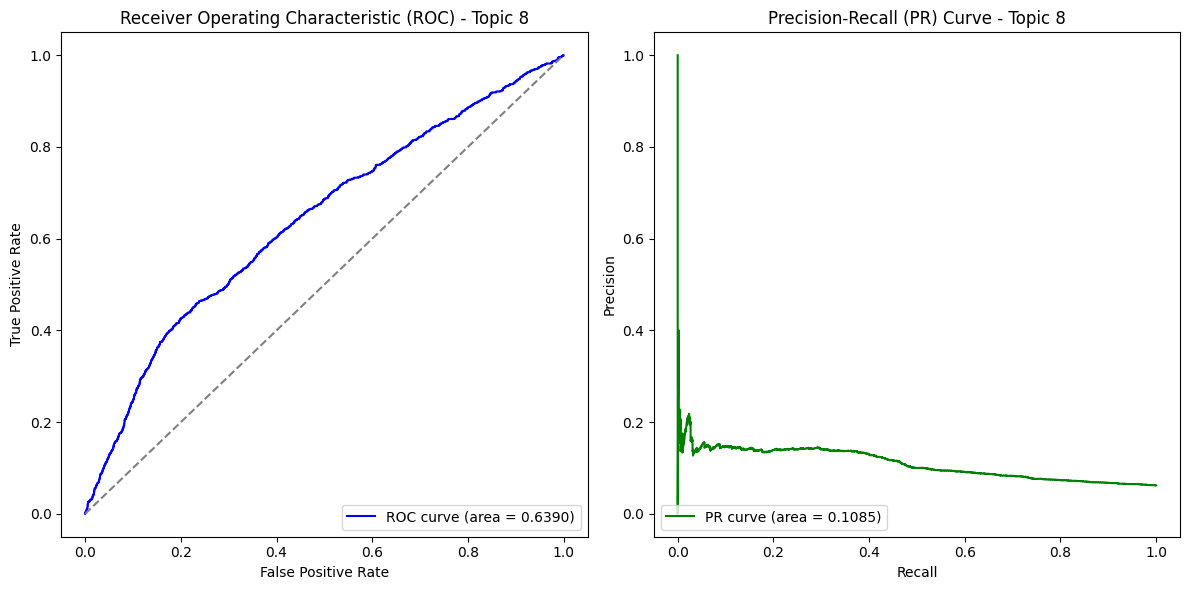

Evaluating topic 9
Topic 9 - auROC: 0.6691, auPR: 0.1083, F1: 0.0000


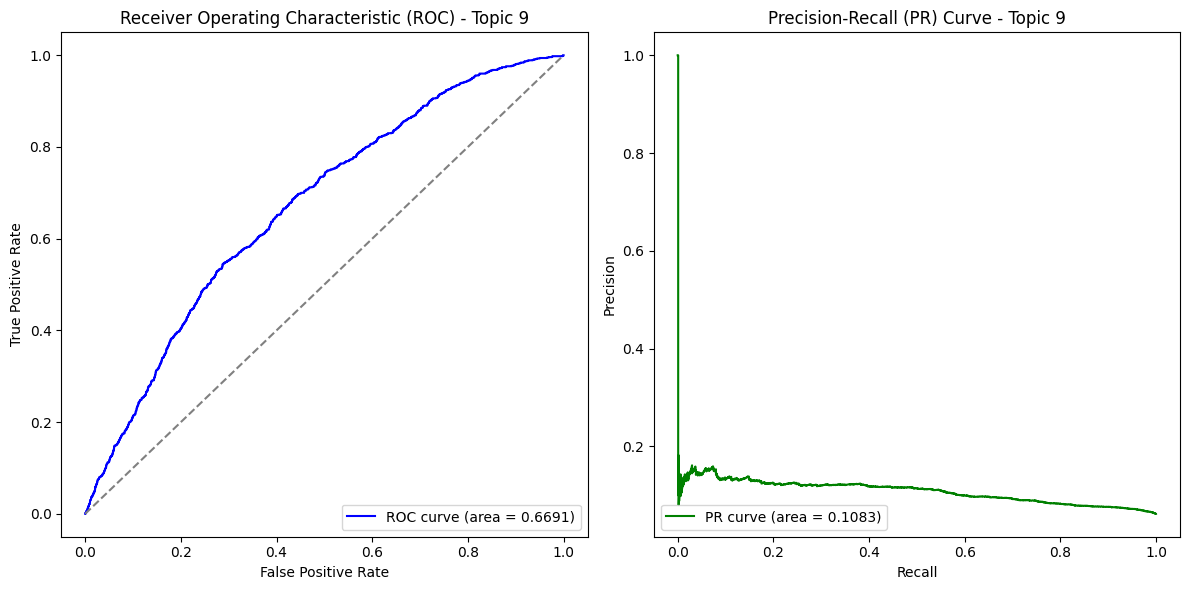

Evaluating topic 10
Topic 10 - auROC: 0.6731, auPR: 0.1293, F1: 0.0000


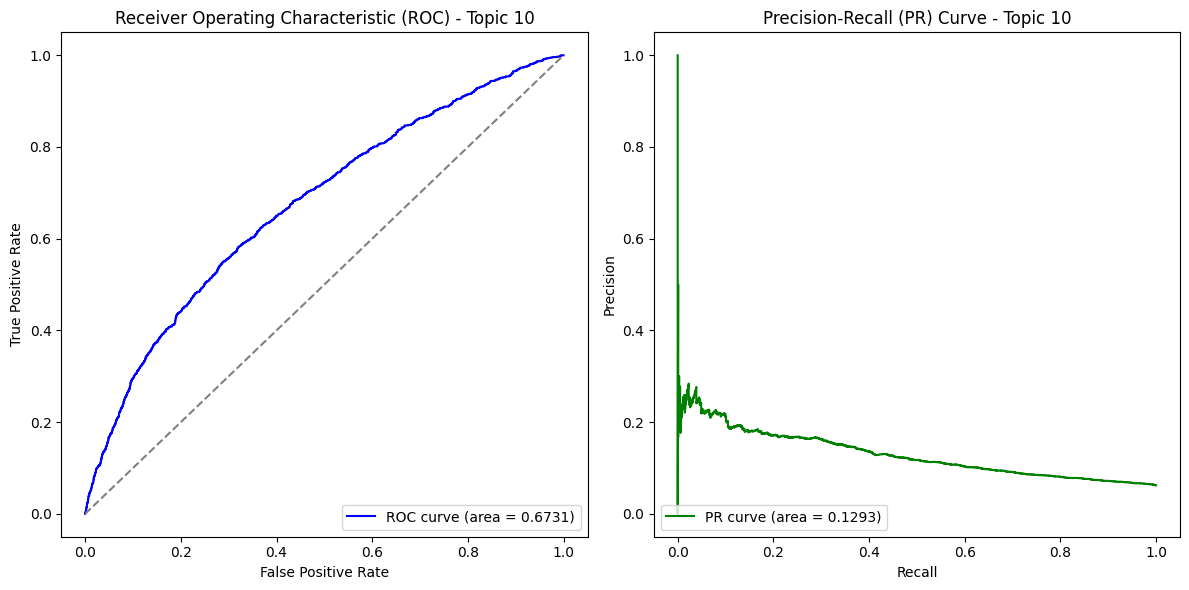

Evaluating topic 11
Topic 11 - auROC: 0.6590, auPR: 0.1158, F1: 0.0000


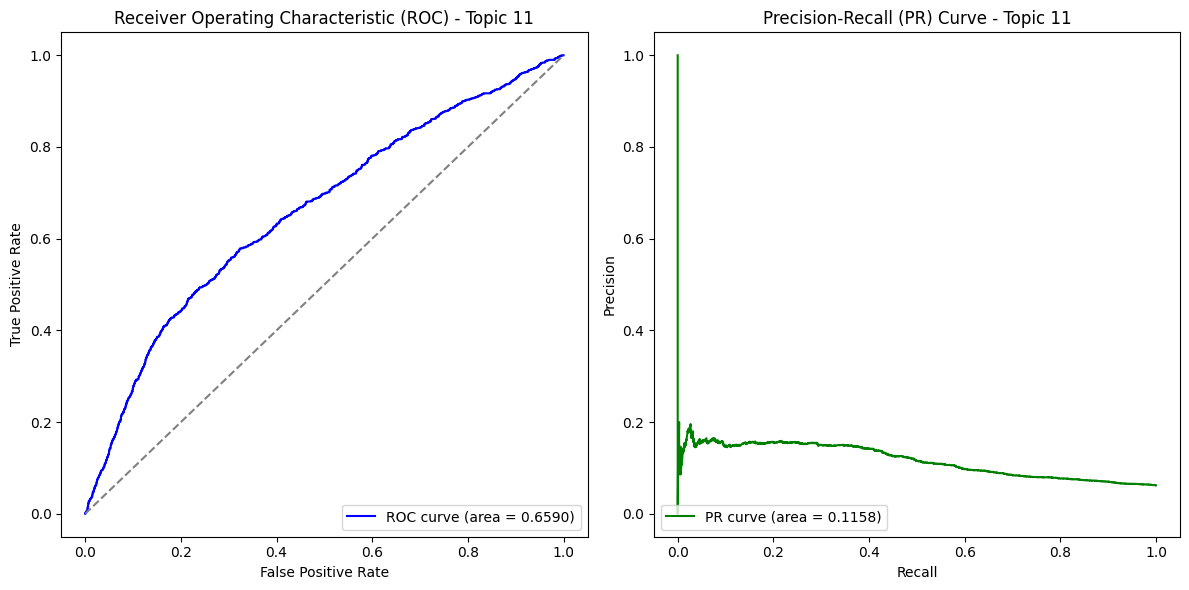

Evaluating topic 12
Topic 12 - auROC: 0.5880, auPR: 0.0807, F1: 0.0000


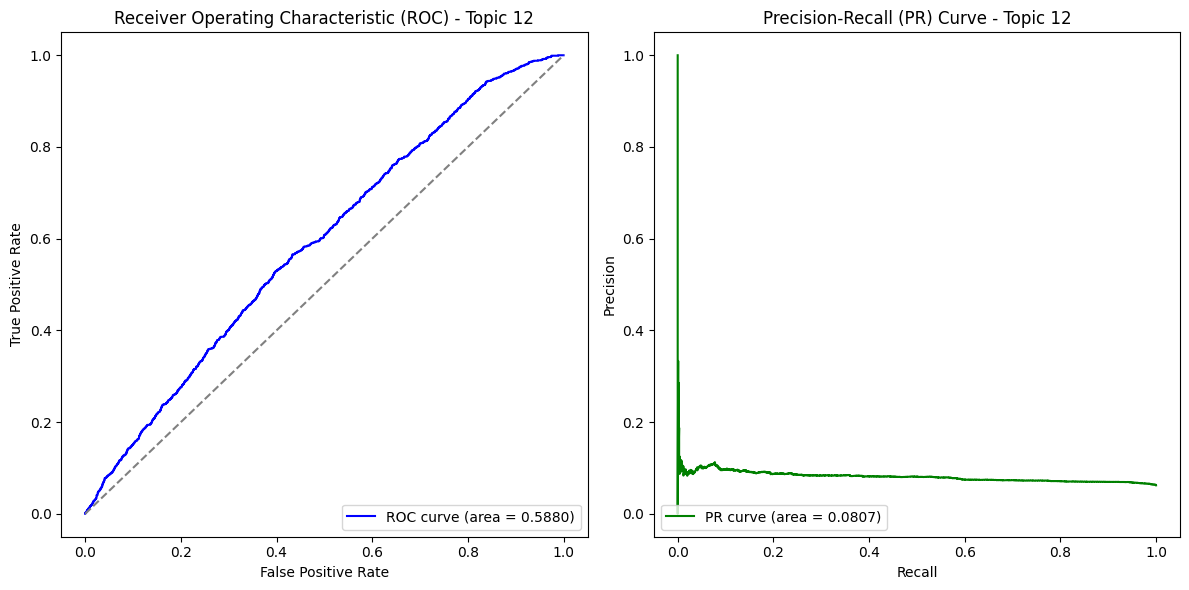

Evaluating topic 13
Topic 13 - auROC: 0.6579, auPR: 0.0942, F1: 0.0000


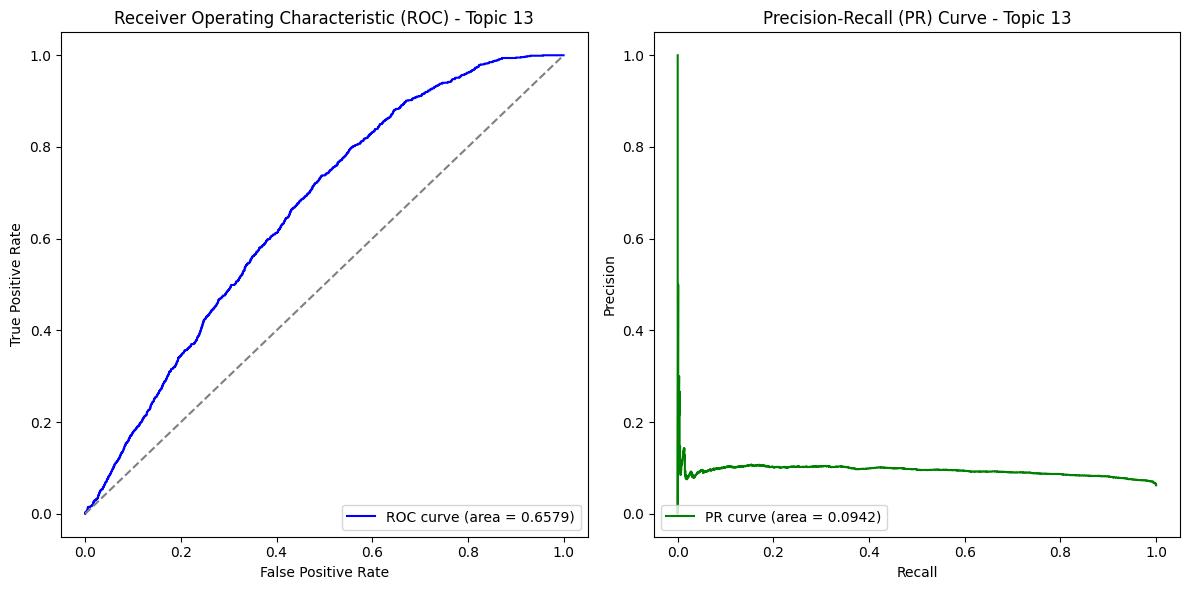

Evaluating topic 14
Topic 14 - auROC: 0.6431, auPR: 0.1120, F1: 0.0000


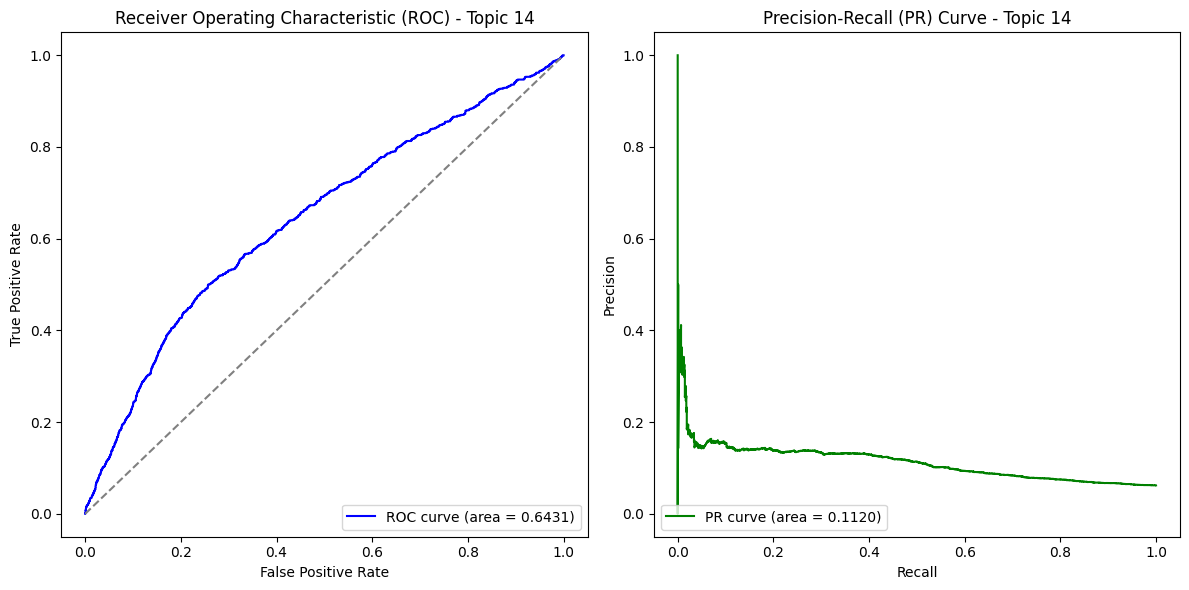

Evaluating topic 15
Topic 15 - auROC: 0.6151, auPR: 0.0849, F1: 0.0000


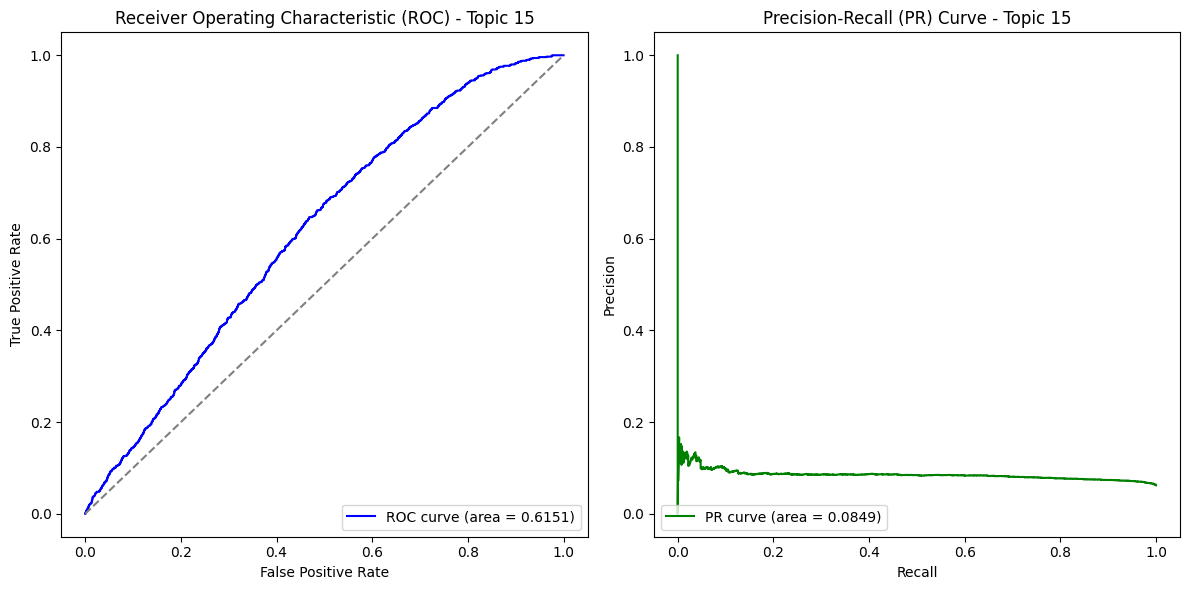

Evaluating topic 16
Topic 16 - auROC: 0.6757, auPR: 0.1115, F1: 0.0000


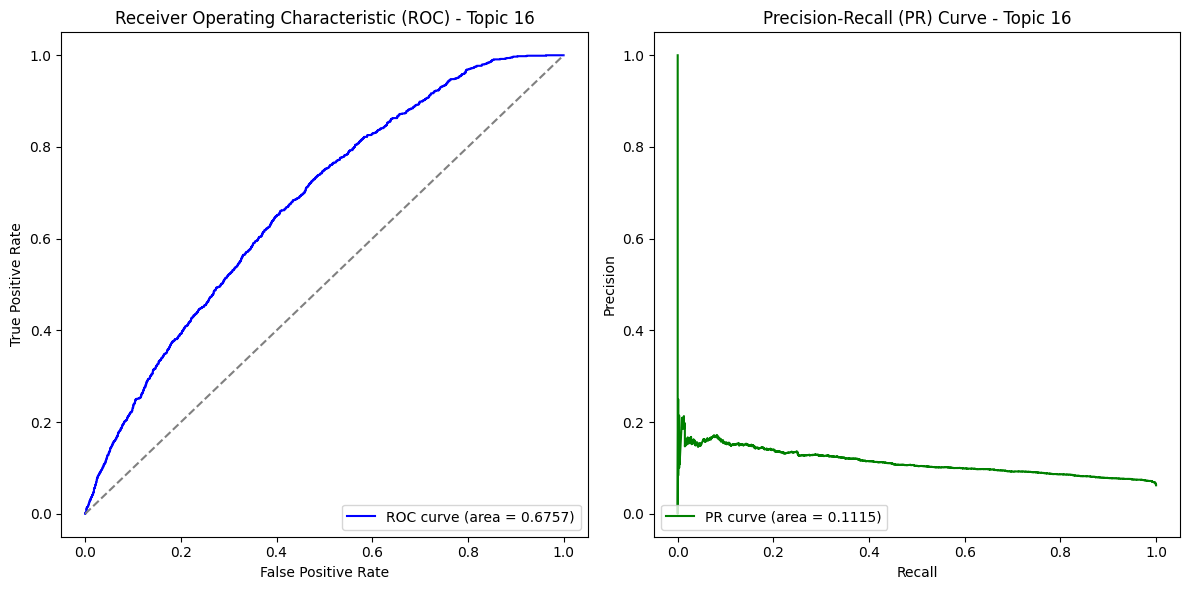

Evaluating topic 17
Topic 17 - auROC: 0.5997, auPR: 0.0753, F1: 0.0000


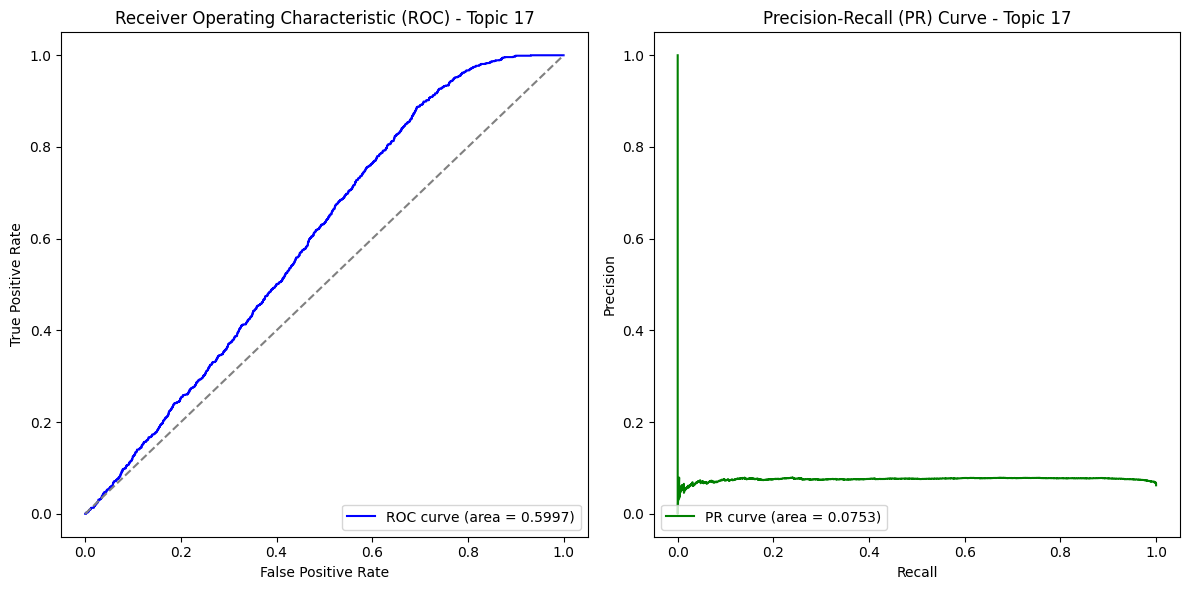

In [27]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [28]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.6331 ± 0.0434
Mean auPR: 0.0980 ± 0.0196
Mean F1: 0.0000 ± 0.0000
Exact Match Accuracy: 0.0000
Hamming Accuracy: 0.9378


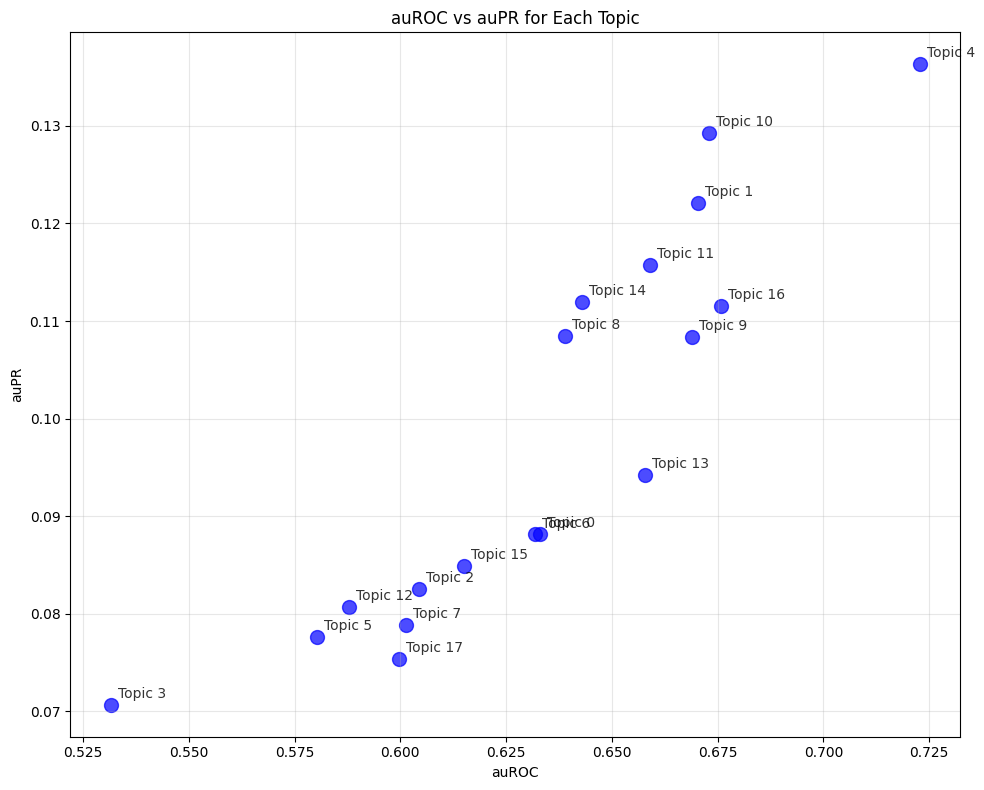

In [29]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

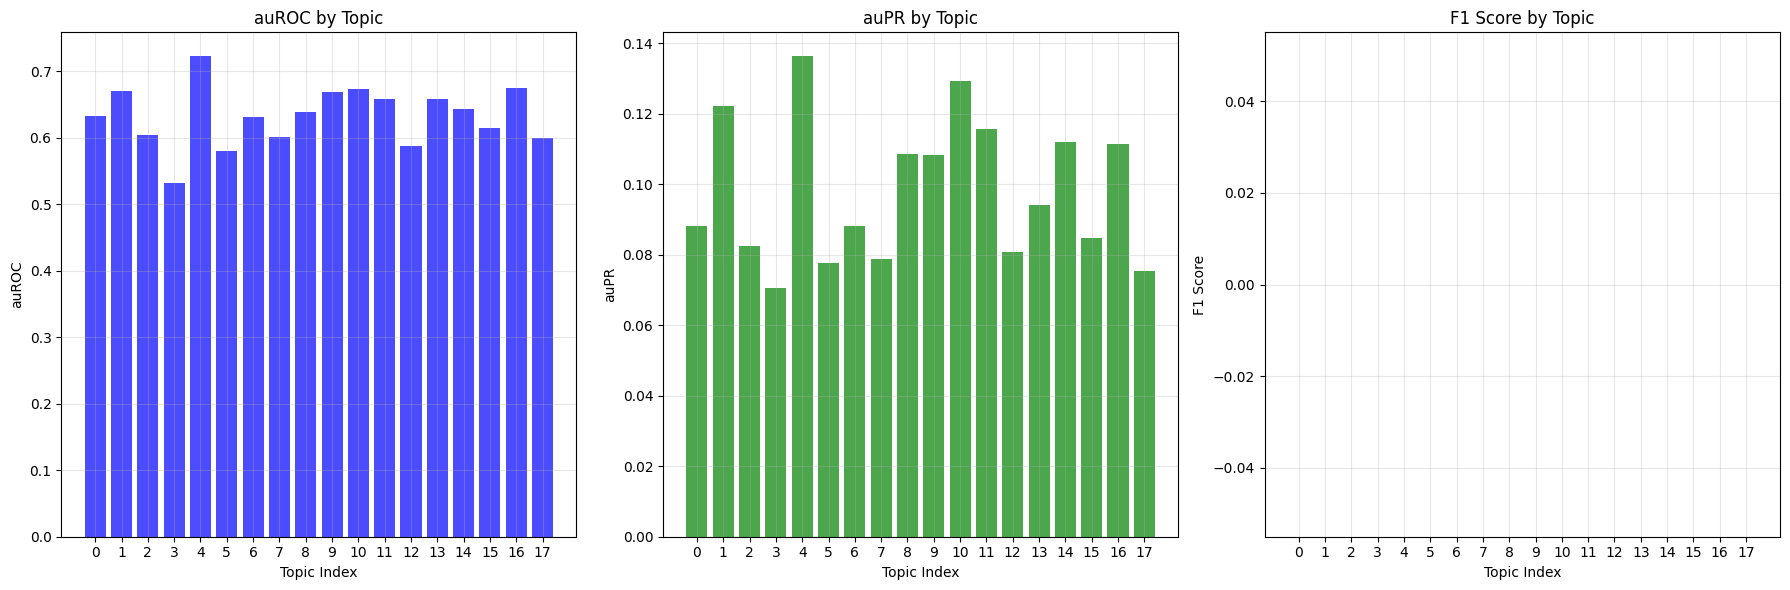

In [30]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

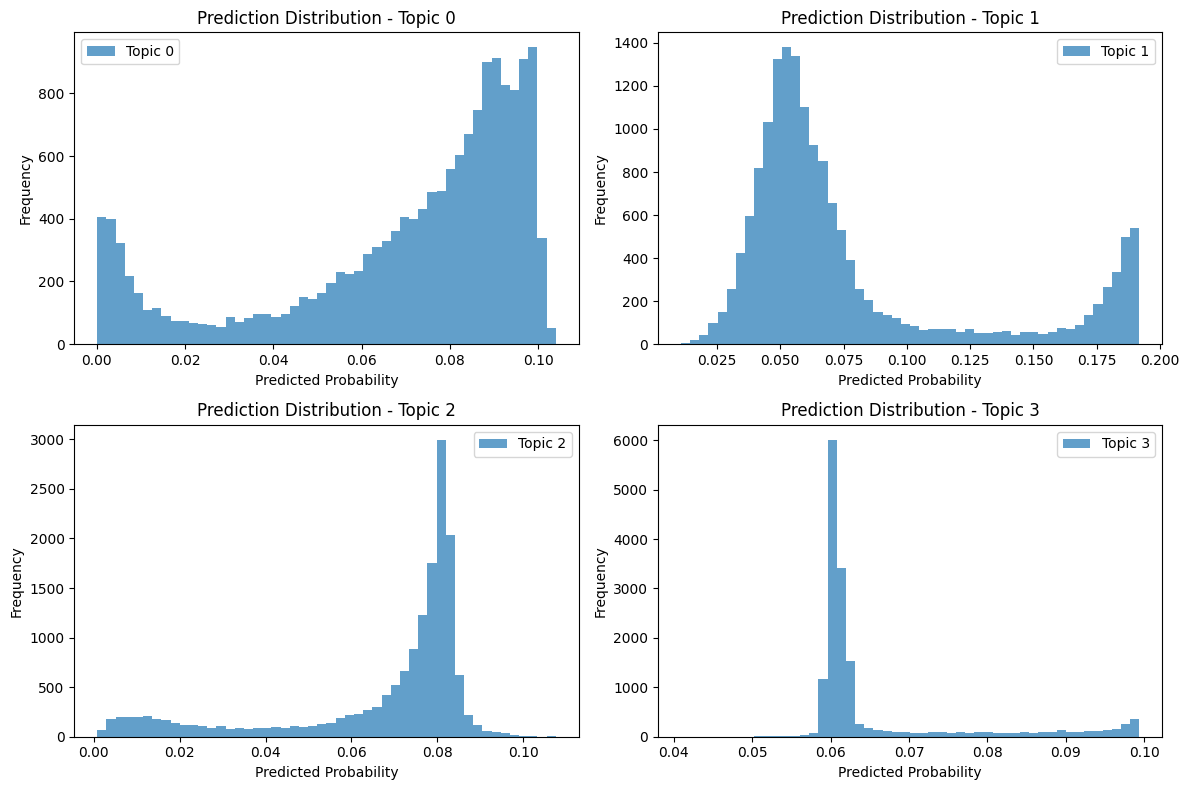


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.00266653 0.180773   0.00806949 0.08053726 0.16662386 0.01718097
 0.00283941 0.00484719 0.14307596 0.02321955 0.1271036  0.1667486
 0.02580442 0.00241501 0.15871502 0.01118919 0.00413101 0.00506965]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.00109835 0.17442924 0.00413067 0.06646083 0.18150549 0.01114915
 0.00122182 0.00231256 0.1365353  0.01537442 0.14460562 0.16546953
 0.01908667 0.00099517 0.15950134 0.00687038 0.00196191 0.00287099]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.00167448 0.17824157 0.00561643 0.0711782  0.18092749 0.01352697
 0.00184796 0.00325536 0.13880192 0.01818242 0.14233005 0.16670218
 0.0220683  0.00152609 0.15474911 0.00869314 0.00270279 0.00387621]
  Actual:    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

In [31]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [32]:
# Evaluate model on test dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ray/miniforge3/envs/deepmsn/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/ray/miniforge3/envs/deepmsn/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ray/miniforge3/envs/deepmsn/lib/python3.12/site-packages/torch/utils/data/dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/home/ray/DeepMSN/datasets/topic_datasets.py", line 45, in __getitem__
    bed_entry = self.bed_entries[idx]
                ~~~~~~~~~~~~~~~~^^^^^
IndexError: list index out of range


In [ ]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

In [ ]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")

In [ ]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)

In [ ]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")

In [ ]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()